In [1]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from os.path import join as pjoin
from scipy.stats import zscore
import hypertools as hyp
import pandas as pd
from IPython.display import HTML
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
from mpl_toolkits.mplot3d import Axes3D
import runpy
%matplotlib inline

In [2]:
# import functions from other scripts
file_globals = runpy.run_path('digit_classification.py')
get_digit_indices = file_globals['get_digit_indices']

# Load data

In [3]:
# load data
results_dir = '/data/BnB_USER/oliver/somato/scratch/crossval_projection'

# for first run is training, second is test
proj_data_run1train_npy = pjoin(results_dir, 'proj_run1_is_train.npy')
trained_srms_run1train_npy = pjoin(results_dir, 'trainedsrms_run1_is_train.npy')
with open(proj_data_run1train_npy, 'rb') as inf:
    proj_data_run1train = np.load(inf)
with open(trained_srms_run1train_npy, 'rb') as inf:
    trained_srms_run1train = np.load(inf)
    
# second run is training, first is test
proj_data_run2train_npy = pjoin(results_dir, 'proj_run2_is_train.npy')
trained_srms_run2train_npy = pjoin(results_dir, 'trainedsrms_run2_is_train.npy')

with open(proj_data_run2train_npy, 'rb') as inf:
    proj_data_run2train = np.load(inf)
with open(trained_srms_run1train_npy, 'rb') as inf:
    trained_srms_run2train = np.load(inf)

In [4]:
# make lists of data frames for hypertools plotting

# first run is training, second is test
projected_dfs_run2 = []
trained_srms_dfs_run1 = []

for sub_idx in range(proj_data_run1train.shape[0]):
    df = pd.DataFrame(proj_data_run1train[sub_idx].T)
    projected_dfs_run2.append(df)
    srm_df = pd.DataFrame(trained_srms_run1train[sub_idx].T)
    trained_srms_dfs_run1.append(srm_df)

# second run is training, first is test
projected_dfs_run1 = []
trained_srms_dfs_run2 = []

for sub_idx in range(proj_data_run2train.shape[0]):
    df = pd.DataFrame(proj_data_run2train[sub_idx].T)
    projected_dfs_run1.append(df)
    srm_df = pd.DataFrame(trained_srms_run2train[sub_idx].T)
    trained_srms_dfs_run2.append(srm_df)

In [5]:
# create finger-color arrays

# get ndarrays (nfingers, nvols)
digits_run1, digits_run2 = get_digit_indices()

# turn into flat arrays with values 1-5
digit_colors_run1, digit_colors_run2 = np.zeros(shape=(256)), np.zeros(shape=(256))
for finger_i in range(1,6):
    digit_colors_run1[digits_run1[finger_i-1]] = finger_i
    digit_colors_run2[digits_run2[finger_i-1]] = finger_i

# for some reason, the first entry in the first run's digit array is a 5, but should be a 1...
digit_colors_run1[0]=1.

## Helper function

In [6]:
def to_matrix_form(training_dfs, test_df,
                   training_digits, test_digits):
    """
    Take my list of arrays and bring them into suitable matrices of data and labels
    for the classification.
    """
    training_matrix = np.vstack([df.as_matrix() for df in training_dfs])
    test_matrix = test_df.as_matrix()
    training_labels = np.tile(training_digits, len(training_dfs))
    
    return training_matrix, test_matrix, training_labels

# within subject, cross run

Train classifier on one run and test on the other run of the same subject. This does not allow much cross-validation. But we may still vary parameter k.

In [7]:
# kn parameters to iterate over
kn_range = range(1,51,2)

# results array of shape (kn_range, nruns, nsubjecs)
results = np.zeros((len(kn_range), 2, len(projected_dfs_run1)))

for kn in kn_range:
    for sub_i in range(len(projected_dfs_run1)):

        # train on run 1 and test on 
        train_run = zscore(projected_dfs_run1[sub_i].as_matrix(), axis=0)
        test_run = zscore(projected_dfs_run2[sub_i].as_matrix(), axis=0)
        neigh = KNeighborsClassifier(n_neighbors=kn)
        neigh.fit(train_run, digit_colors_run1)
        results[kn_range.index(kn), 0, sub_i] = neigh.score(test_run, digit_colors_run2)

        # train on run 1 and test on 2
        train_run = zscore(projected_dfs_run2[sub_i].as_matrix(), axis=0)
        test_run = zscore(projected_dfs_run1[sub_i].as_matrix(), axis=0)
        neigh = KNeighborsClassifier(n_neighbors=kn)
        neigh.fit(train_run, digit_colors_run2)
        results[kn_range.index(kn), 0, sub_i] = neigh.score(test_run, digit_colors_run1)


In [8]:
# average result over subjects
av_results = np.average(results, axis=2)
av_results = np.average(av_results, axis=1)
av_results.shape

(25,)

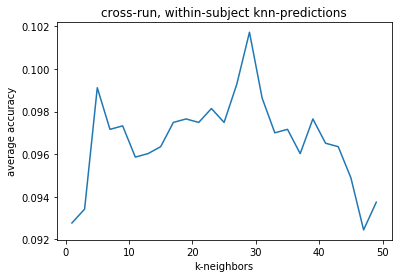

In [9]:
plt.xlabel('k-neighbors')
plt.ylabel('average accuracy')
plt.title('cross-run, within-subject knn-predictions')
sns.lineplot(x=kn_range, y=av_results)

Within-subject digit classification performs at chance level.

# within run, cross subject

For a given run, train the classifier on all subjects but one and test respectively. Here, we could think about z-scoring across all subjects data, instead of seperately for subjects.

In [10]:
kn_range = range(1,151,2)

# results array
results = np.zeros((len(kn_range), 2, len(projected_dfs_run1)))


for kn in kn_range:
    for sub_i in range(len(projected_dfs_run1)):
        # within first run
        test_df = projected_dfs_run1[sub_i]
        train_dfs = [df for i, df in enumerate(projected_dfs_run1) if i != sub_i]
        training_matrix, test_matrix, training_labels = to_matrix_form(train_dfs, test_df, 
                                                                       digit_colors_run1, digit_colors_run1)
        # z-score over all training subjects
        training_matrix = zscore(training_matrix, axis=0)
        neigh = KNeighborsClassifier(n_neighbors=kn)
        neigh.fit(training_matrix, training_labels)
        results[kn_range.index(kn), 0, sub_i] = neigh.score(zscore(test_matrix, axis=0), digit_colors_run1)

        # within second run
        test_df = projected_dfs_run2[sub_i]
        train_dfs = [df for i, df in enumerate(projected_dfs_run2) if i != sub_i]
        training_matrix, test_matrix, training_labels = to_matrix_form(train_dfs, test_df, 
                                                                       digit_colors_run2, digit_colors_run2)
        
        # z-score over all training subjects
        training_matrix = zscore(training_matrix, axis=0)
        neigh = KNeighborsClassifier(n_neighbors=kn)
        neigh.fit(training_matrix, training_labels)
        results[kn_range.index(kn), 1, sub_i] = neigh.score(zscore(test_matrix, axis=0), digit_colors_run2)

In [11]:
# average result over subjects
av_results = np.average(results, axis=2)
av_results = np.average(av_results, axis=1)
av_results.shape

(75,)

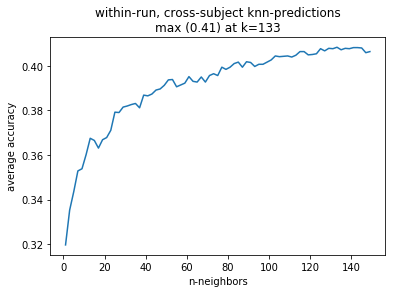

In [12]:
plt.xlabel('n-neighbors')
plt.ylabel('average accuracy')
plt.title("""within-run, cross-subject knn-predictions
max (%.2f) at k=%i""" % (np.max(av_results), kn_range[np.argmax(av_results)]))
sns.lineplot(x=kn_range, y=av_results)

# cross run and subject


2-fold cross-validation just like in the scheme used for projecting the original data.

In [13]:
kn_range = range(1,51,2)

# results array
results = np.zeros((len(kn_range), 2, len(projected_dfs_run1)))


for kn in kn_range:
    for sub_i in range(len(projected_dfs_run1)):
        # first run as training
        test_df = projected_dfs_run2[sub_i]
        train_dfs = [df for i, df in enumerate(projected_dfs_run1) if i != sub_i]
        training_matrix, test_matrix, training_labels = to_matrix_form(train_dfs, test_df, 
                                                                       digit_colors_run1, digit_colors_run2)
        # z-score over all training subjects
        training_matrix = zscore(training_matrix, axis=0)
        neigh = KNeighborsClassifier(n_neighbors=kn)
        neigh.fit(training_matrix, training_labels)
        results[kn_range.index(kn), 0, sub_i] = neigh.score(zscore(test_matrix, axis=0), digit_colors_run2)
        # second run as training
        test_df = projected_dfs_run1[sub_i]
        train_dfs = [df for i, df in enumerate(projected_dfs_run2) if i != sub_i]
        training_matrix, test_matrix, training_labels = to_matrix_form(train_dfs, test_df, 
                                                                       digit_colors_run2, digit_colors_run1)
        # z-score over all training subjects
        training_matrix = zscore(training_matrix, axis=0)
        neigh = KNeighborsClassifier(n_neighbors=kn)
        neigh.fit(training_matrix, training_labels)
        results[kn_range.index(kn), 1, sub_i] = neigh.score(zscore(test_matrix, axis=0), digit_colors_run2)

In [14]:
av_results = np.average(results, axis=2)
av_results = np.average(av_results, axis=1)
av_results.shape

(25,)

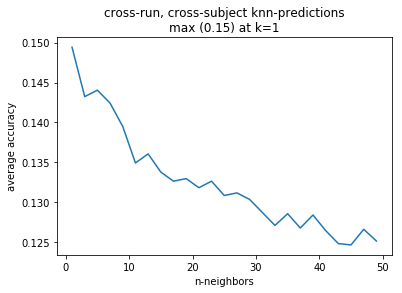

In [15]:
plt.xlabel('n-neighbors')
plt.ylabel('average accuracy')
plt.title("""cross-run, cross-subject knn-predictions
max (%.2f) at k=%i""" % (np.max(av_results), kn_range[np.argmax(av_results)]))
sns.lineplot(x=kn_range, y=av_results)

# TODO:

- knn is not suited for data with too many features (how many?)
- depending on how you z-score the accuracies change. How to best z-score??